### Brain Tumor Detection and Classification using Deep learning CNN models


**Goal:** 
The goal of Brain tumor detection and classification using Convolutional Neural Networks (CNNs) is to develop an accurate and efficient mechanism for automatically identifying the presence of tumors in medical images such as MRI scans, and categorizing them into 3 specific tumor types pituitary, gliomas or meningiomas.

**Data Problem:** 
The data task is to fine-tune pretrained networks and train multiple CNN models on the Brain MRI dataset that can group the MRI image into No Tumor or pituitary, gliomas or meningiomas tumor catgories.

**Expected Results:** 
The expected results of this project is a quality model with high accuracy that can be used to predict for future/unseen Brain MRI images, whether they had a tumor and if so what type of tumor.

We will draw insights from this model by conducting an analysis on an existing dataset of Brain MRI images and identifying characteristics 
to distinguish between various tumor subtypes (e.g., glioblastoma, meningioma) to making accurate predictions.

 We will also be locally analyzing this model and evaluating its class prediction process for individual Brain MRI images.

**Data**

The data is sourced from Kaggle.
https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri



In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas  as pd
import random
import seaborn as sns
from tqdm import tqdm


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score
import ipywidgets as widgets

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,LSTM, RepeatVector, TimeDistributed,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras.applications import DenseNet201, EfficientNetB3
from keras.applications.vgg19 import VGG19,preprocess_input

from PIL import Image
from IPython.display import display,clear_output
from colorama import Fore


import warnings
warnings.filterwarnings('ignore')

In [3]:
train_datasets = "./data/Training/"
validation_datasets = "./data/Testing/"

In [4]:
print('Training Distribution of Brain Tumor Data:\n')
path, dirs, files = next(os.walk('./data/Training/glioma_tumor'))
print(f'glioma: {len(files)}')
path, dirs, files = next(os.walk('./data//Training/meningioma_tumor'))
print( f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('./data/Training/no_tumor'))
print(f'notumor: {len(files)}')
path, dirs, files = next(os.walk('./data/Training/pituitary_tumor'))
print( f'pituitary: {len(files)}\n')

print( 'Testing Distribution of Brain Tumor Data::\n')
path, dirs, files = next(os.walk('./data/Testing/glioma_tumor'))
print( f'glioma: {len(files)}')
path, dirs, files = next(os.walk('./data/Testing/meningioma_tumor'))
print( f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('./data/Testing/no_tumor'))
print(f'notumor: {len(files)}')
path, dirs, files = next(os.walk('./data/Testing/pituitary_tumor'))
print( f'pituitary: {len(files)}\n')

Training Distribution of Brain Tumor Data:

glioma: 826
meningioma: 822
notumor: 395
pituitary: 827

Testing Distribution of Brain Tumor Data::

glioma: 100
meningioma: 115
notumor: 105
pituitary: 74



### Data Overview and Visualization

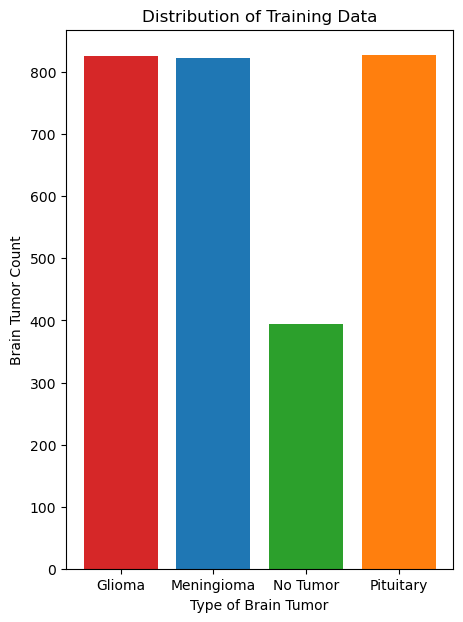

In [5]:
data = {'Glioma': 826, 'Meningioma': 822, 'No Tumor': 395, 'Pituitary': 827}


labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
typex = data.keys()
tumor_count = data.values()

total_train = sum(data.values())
fig = plt.figure(figsize=(5,7))

colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

plt.bar(typex, tumor_count, label=labels,  color=colors)

plt.xlabel("Type of Brain Tumor")
plt.ylabel("Brain Tumor Count")
plt.title("Distribution of Training Data")
plt.show()


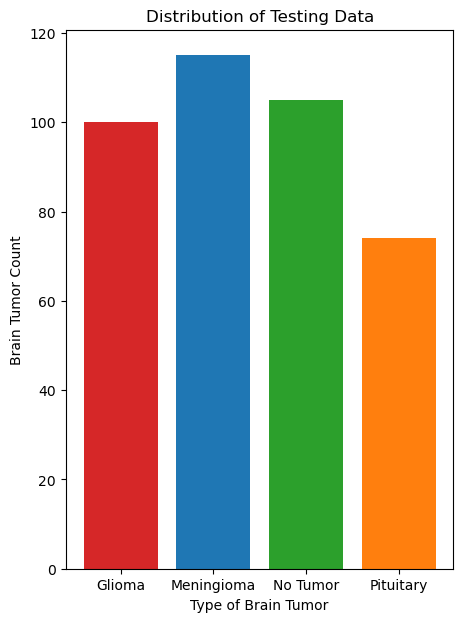

In [6]:
testdata = {'Glioma': 100, 'Meningioma': 115, 'No Tumor': 105, 'Pituitary': 74}

labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
typex = testdata.keys()
values = testdata.values()

total_test = sum(testdata.values())

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values,label=labels,  color=colors)


plt.xlabel("Type of Brain Tumor")
plt.ylabel("Brain Tumor Count")
plt.title("Distribution of Testing Data")
plt.show()

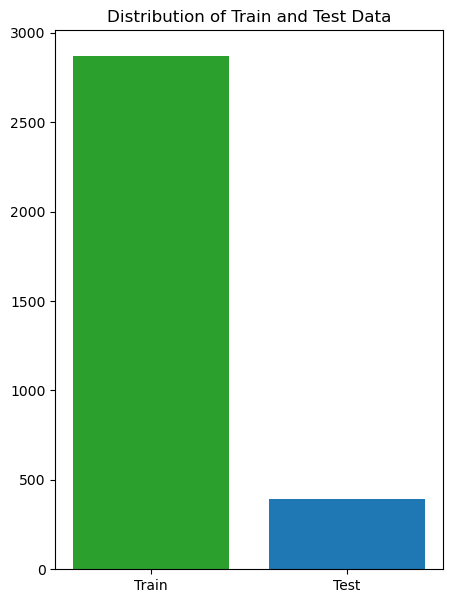

In [7]:
total_labels = ['Train', 'Test']
total_counts = [total_train, total_test]

fig = plt.figure(figsize=(5,7))

colors = ['tab:green', 'tab:blue']
plt.bar(total_labels, total_counts, color=colors)

plt.title("Distribution of Train and Test Data")
plt.show()


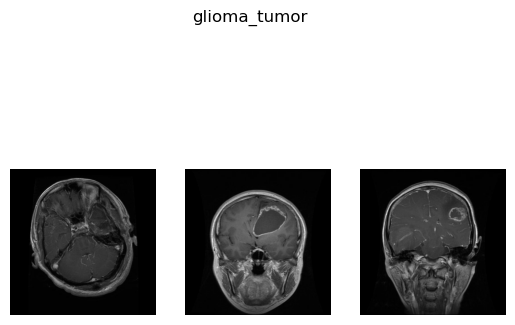

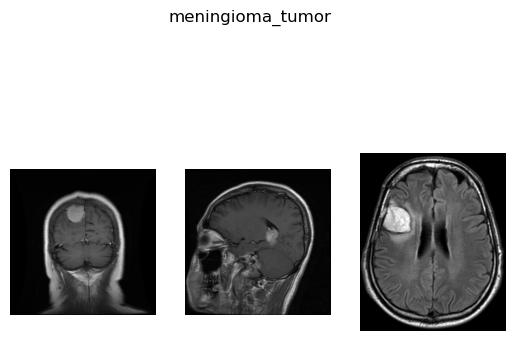

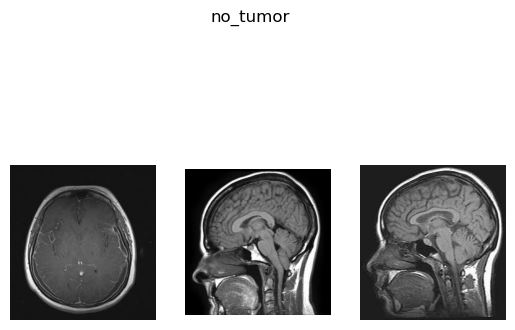

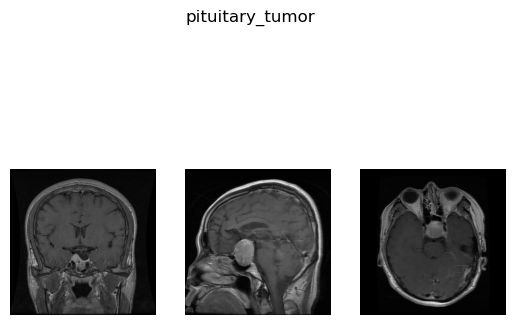

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the folders containing the images
folders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Set the number of images to display from each folder
num_images_to_show = 3

# Loop through the folders and display random images
for folder in folders:
    # Get a random sample of images from the folder
    images = np.random.choice(os.listdir(os.path.join('./data/Training', folder)), size=num_images_to_show)

    # Create a figure and subplot for each image
    fig, axs = plt.subplots(1, len(images))
    # Set the figure title
    fig.suptitle(folder)
    # Iterate through the images and display them
    for i, image in enumerate(images):
        # Load the image
        img = plt.imread(os.path.join('./data/Training', folder, image))

        # Display the image
        axs[i].imshow(img)
        axs[i].axis('off')
        # Show the figure
    plt.show()

**Data preprocessing**

- The MRIs images are resized as per requirement of the  models
- The “preprocess_input” function is used for pre-processing the images along with ImageDataGenerator.
- The “ImageDataGenerator” takes the original image and replaces it with a new pre-processed image.


**Hyperparameter fine-tuning**

The following hyperparamters are considered for fine-tuning the models
- optimizers, dropout, number of epochs and batch size.

**Model Evaluation**

We will consider pre-trained models VGG19, DenseNet201 and EfficientNetB0 for transfer learning and fine tuning the pre-trained Network on the 
Brain MRI segmentation dataset to extract features and classfiy.

We will use  your `loss` and  `accuracy` along with the classfication matrix as our `metric` to evaluate the models.

### VGG19

We fine tune VGG19 by performing the 
- One `Flatten` layer to flatten the results of VGG19
- One `Dense` layer with 4608 nodes and `relu` activation and drop_out
- One `Dense` output layer 1152 node and with `softmax` activation
- One `Dense` output layer 4 node  with `softmax` activation to summarize a result into various output classes.

In [ ]:
batch_size = 32
image_size = 224
epochs = 3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):

    train_datasets_generator = ImageDataGenerator(rescale=1./255,
                                                  shear_range = 0.2, 
                                                  zoom_range = 0.2, 
                                                  horizontal_flip = True,
                                                  vertical_flip= True,
                                                  width_shift_range=0.3,
                                                  fill_mode = "nearest")



    validation_datasets_generator = ImageDataGenerator(rescale=1.0/255)


    train_datasets_generator_data = train_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = train_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        classes= ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor'],
        class_mode = "categorical"
    )

    validation_datasets_generator_data = validation_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = validation_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        classes= ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor'],
        class_mode = "categorical"
    )

    return train_datasets_generator_data, validation_datasets_generator_data


In [ ]:
train_data , validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)


Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
train_data.class_indices

{'pituitary_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'glioma_tumor': 3}

In [ ]:
base_model = VGG19(input_shape = (224,224,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(4, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4608)           │             

 Total params: 140,948,676 (537.68 MB)

 Trainable params: 120,924,292 (461.29 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
model_01.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

In [ ]:
checkpoint= ModelCheckpoint("densenet101.keras",
                            monitor= "val_loss",
                            mode= "min",
                            save_best_only= True,
                            verbose=1)

earlystop= EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 10,
                         verbose=1,
                         restore_best_weights= True)


reduce_lr= ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,   
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)


callbacks=[earlystop, checkpoint, reduce_lr]

In [ ]:
nb_train_samples= 2870
nb_validation_samples= 394
epochs= 8
batch_size= 32

history= model_01.fit(train_data,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=callbacks,
                   validation_data= validation_data,
                   validation_steps= nb_validation_samples//batch_size,
                    shuffle= True)

Epoch 1/8
13/89 ━━━━━━━━━━━━━━━━━━━━ 3:24 3s/step - accuracy: 0.2444 - loss: 3.5908

In [ ]:
import numpy as np
# Evaluate the model
loss, accuracy = model_01.evaluate(validation_data, batch_size = batch_size, verbose=2)
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")

# Generate predictions on the validation data
y_pred = np.argmax(model_01.predict(validation_data,nb_validation_samples//batch_size + 1 ), axis=1)
y_pred

y_true = validation_data.classes

13/13 - 29s - 2s/step - accuracy: 0.4061 - loss: 1.4418
Validation loss: 1.4418
Validation accuracy: 0.4061
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step


**Evaluate VGG fine-tuned model**

In [ ]:
# Print the classification report
print("VGG19 Classification report:")

# Print the classification report with labels
# Get the class labels
target_names= ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']

print(classification_report(y_true, y_pred, target_names=target_names))

# prompt: save classification report as png

import matplotlib.pyplot as plt
import seaborn as sns

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=target_names)


VGG19 Classification report:
                  precision    recall  f1-score   support

 pituitary_tumor       0.19      0.39      0.26        74
meningioma_tumor       0.15      0.03      0.06       115
        no_tumor       0.33      0.37      0.35       105
    glioma_tumor       0.20      0.20      0.20       100

        accuracy                           0.23       394
       macro avg       0.22      0.25      0.22       394
    weighted avg       0.22      0.23      0.21       394



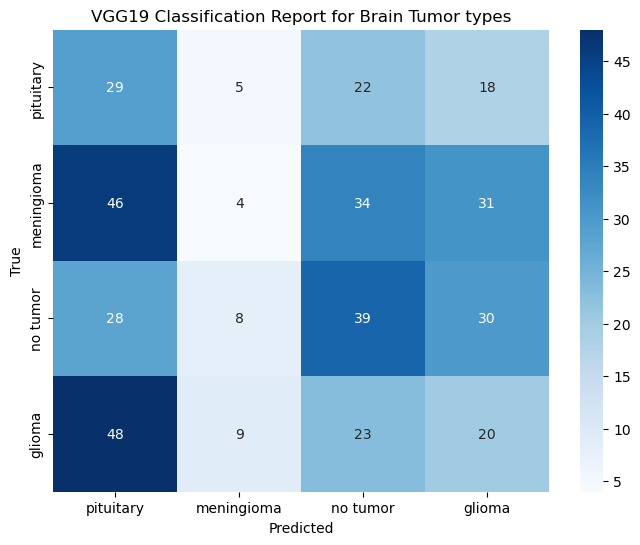

In [ ]:
import matplotlib.pyplot as plt

target_names= ['pituitary', 'meningioma','no tumor', 'glioma']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the classification report
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("VGG19 Classification Report for Brain Tumor types")
plt.show()

# Save the figure as a PNG image
fig.savefig("VGG19Classification_report.png")

In [23]:

import numpy as np

def plot_training_curves(history):
    # Plotting training and validation loss
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.show()

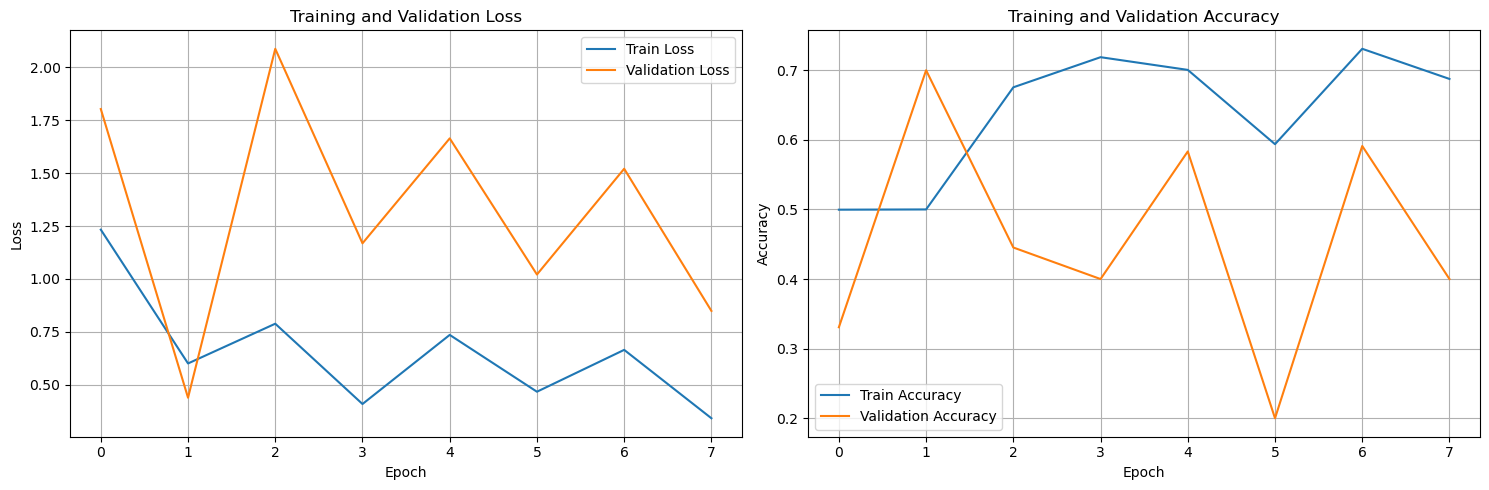

In [ ]:
plot_training_curves(history)

***Predict for a test image***

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


<h3 style='color:green;'>VGG19 Predicted class: meningioma_tumor</h3>

<h3 style='color:blue;'>VGG19 Confidence: 100.00%</h3>

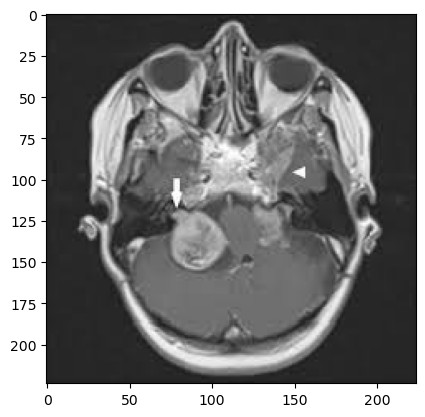

In [ ]:
from IPython.display import display, Markdown
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.preprocessing import image

imagePath = "./data/Testing/meningioma_tumor/image(100).jpg"

img = image.load_img(imagePath, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model_01.predict(x)

class_labels = ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']

predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

markdown_text = f"<h3 style='color:green;'>VGG19 Predicted class: {predicted_class_label}</h3>"
display(Markdown(markdown_text))

markdown_text2 = f"<h3 style='color:blue;'>VGG19 Confidence: {confidence*100:.2f}%</h3>"
display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()

# Save the figure as a PNG image
fig.savefig("Classification_Report_VGG19.png")

### DenseNet CNN 

In [ ]:
densenet= tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    pooling=None,
    input_shape=(224,224,3)
)

In [ ]:
for layer in densenet.layers:
    layer.trainable= False

In [ ]:
""" Creates the top or head of the model that will be placed on top of the layers """

def customModel(bottom_model, num_class, D=64):
    top_model= bottom_model.output
    top_model= Flatten(name="flatten") (top_model)
    top_model= Dense(D, activation="relu") (top_model)
    top_model= Dropout(0.2) (top_model)
    top_model= Dense(num_class, activation="softmax") (top_model)
    return top_model


In [ ]:
num_classes= 4
Fc_Head= customModel(densenet, num_classes)
model_02 = Model(inputs= densenet.input, outputs= Fc_Head)

In [ ]:
model_02.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

Hyperparameters

In [ ]:
nb_train_samples= 2870
nb_validation_samples= 394
epochs= 15
batch_size= 64

In [ ]:
checkpoint= ModelCheckpoint("./model/densenet101.keras",
                            monitor= "val_loss",
                            mode= "min",
                            save_best_only= True,
                            verbose=1)

earlystop= EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 10,
                         verbose=1,
                         restore_best_weights= True)


reduce_lr= ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,   
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)


callbacks=[earlystop, checkpoint, reduce_lr]

In [ ]:

history= model_02.fit(train_data,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=callbacks,
                   validation_data= validation_data,
                   validation_steps= nb_validation_samples//batch_size,
                    shuffle= True)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.4364 - loss: 1.5649
Epoch 1: val_loss improved from inf to 1.34103, saving model to ./model/densenet101.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4387 - loss: 1.5562 - val_accuracy: 0.4792 - val_loss: 1.3410 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.7229 - loss: 0.7295
Epoch 2: val_loss improved from 1.34103 to 1.23580, saving model to ./model/densenet101.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7230 - loss: 0.7291 - val_accuracy: 0.5417 - val_loss: 1.2358 - learning_rate: 1.0000e-04
Epoch 3/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 37s 888ms/step - accuracy: 0.7109 - loss: 0.6702

2024-05-09 20:50:07.629640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-09 20:50:07.998631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 3: val_loss improved from 1.23580 to 0.34973, saving model to ./model/densenet101.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7035 - loss: 0.4984 - val_accuracy: 0.8000 - val_loss: 0.3497 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.7406 - loss: 0.6608
Epoch 4: val_loss did not improve from 0.34973
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 999ms/step - accuracy: 0.7405 - loss: 0.6613 - val_accuracy: 0.4688 - val_loss: 1.3716 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 912ms/step - accuracy: 0.7980 - loss: 0.5599
Epoch 5: val_loss did not improve from 0.34973
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7976 - loss: 0.5601 - val_accuracy: 0.5521 - val_loss: 1.3604 - learning_rate: 1.0000e-04
Epoch 6/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 36s 860ms/step - accuracy: 0.7266 - loss: 0.5927

2024-05-09 20:51:40.998857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 6: val_loss improved from 0.34973 to 0.28559, saving model to ./model/densenet101.keras


2024-05-09 20:51:41.363673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7340 - loss: 0.4252 - val_accuracy: 0.8000 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8051 - loss: 0.5171
Epoch 7: val_loss did not improve from 0.28559
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8046 - loss: 0.5173 - val_accuracy: 0.6198 - val_loss: 1.0164 - learning_rate: 1.0000e-04
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8169 - loss: 0.4735
Epoch 8: val_loss did not improve from 0.28559
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8167 - loss: 0.4738 - val_accuracy: 0.4948 - val_loss: 1.4089 - learning_rate: 1.0000e-04
Epoch 9/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 39s 937ms/step - accuracy: 0.8594 - loss: 0.4836

2024-05-09 20:53:16.666454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 9: val_loss did not improve from 0.28559
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8445 - loss: 0.3063 - val_accuracy: 0.7000 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 10/30


2024-05-09 20:53:17.046044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.8207 - loss: 0.4878
Epoch 10: val_loss did not improve from 0.28559
44/44 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8209 - loss: 0.4875 - val_accuracy: 0.5885 - val_loss: 1.2421 - learning_rate: 1.0000e-04
Epoch 11/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8452 - loss: 0.4176
Epoch 11: val_loss did not improve from 0.28559

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8448 - loss: 0.4179 - val_accuracy: 0.6406 - val_loss: 1.0481 - learning_rate: 1.0000e-04
Epoch 12/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 36s 878ms/step - accuracy: 0.8828 - loss: 0.3172

2024-05-09 20:54:52.288463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 12: val_loss improved from 0.28559 to 0.10523, saving model to ./model/densenet101.keras


2024-05-09 20:54:52.657541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8604 - loss: 0.2431 - val_accuracy: 1.0000 - val_loss: 0.1052 - learning_rate: 1.0000e-05
Epoch 13/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8157 - loss: 0.4659
Epoch 13: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8159 - loss: 0.4656 - val_accuracy: 0.6042 - val_loss: 1.0527 - learning_rate: 1.0000e-05
Epoch 14/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.8234 - loss: 0.4519
Epoch 14: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8238 - loss: 0.4513 - val_accuracy: 0.5990 - val_loss: 1.1033 - learning_rate: 1.0000e-05
Epoch 15/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 38s 912ms/step - accuracy: 0.9297 - loss: 0.3382

2024-05-09 20:56:25.980305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 15: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9222 - loss: 0.2159 - val_accuracy: 0.5000 - val_loss: 0.7759 - learning_rate: 1.0000e-05
Epoch 16/30


2024-05-09 20:56:26.369799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - accuracy: 0.8391 - loss: 0.4161
Epoch 16: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8392 - loss: 0.4160 - val_accuracy: 0.6354 - val_loss: 0.9842 - learning_rate: 1.0000e-05
Epoch 17/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.8451 - loss: 0.4074
Epoch 17: val_loss did not improve from 0.10523

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8450 - loss: 0.4072 - val_accuracy: 0.6250 - val_loss: 1.0538 - learning_rate: 1.0000e-05
Epoch 18/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 36s 870ms/step - accuracy: 0.7656 - loss: 0.5494

2024-05-09 20:58:02.641258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 18: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7805 - loss: 0.3306 - val_accuracy: 0.7000 - val_loss: 0.4219 - learning_rate: 1.0000e-06
Epoch 19/30


2024-05-09 20:58:03.028655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8393 - loss: 0.4216
Epoch 19: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8395 - loss: 0.4213 - val_accuracy: 0.6198 - val_loss: 1.0699 - learning_rate: 1.0000e-06
Epoch 20/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.8380 - loss: 0.4396
Epoch 20: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8382 - loss: 0.4387 - val_accuracy: 0.6406 - val_loss: 1.0646 - learning_rate: 1.0000e-06
Epoch 21/30
 2/44 ━━━━━━━━━━━━━━━━━━━━ 40s 960ms/step - accuracy: 0.9062 - loss: 0.3396

2024-05-09 20:59:46.454940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 21: val_loss did not improve from 0.10523
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8466 - loss: 0.2902 - val_accuracy: 0.3000 - val_loss: 0.9389 - learning_rate: 1.0000e-06
Epoch 22/30


2024-05-09 20:59:46.857979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8351 - loss: 0.4375
Epoch 22: val_loss did not improve from 0.10523

Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
44/44 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8354 - loss: 0.4366 - val_accuracy: 0.6250 - val_loss: 1.1076 - learning_rate: 1.0000e-06
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.


In [ ]:
model_02.save("./model/densenet101.keras")
from tensorflow.keras.models import load_model
model_02 = load_model('./model/densenet101.keras')


In [ ]:
import numpy as np
# Evaluate the model
loss, accuracy = model_02.evaluate(validation_data, batch_size = batch_size, verbose=2)
print(f"Validation loss: {loss:.4f}")
print(f"Validation accuracy: {accuracy:.4f}")

# Generate predictions on the validation data
y_pred = np.argmax(model_02.predict(validation_data,nb_validation_samples//batch_size + 1 ), axis=1)
y_pred

y_true = validation_data.classes


13/13 - 14s - 1s/step - accuracy: 0.6066 - loss: 1.1465
Validation loss: 1.1465
Validation accuracy: 0.6066
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 990ms/step


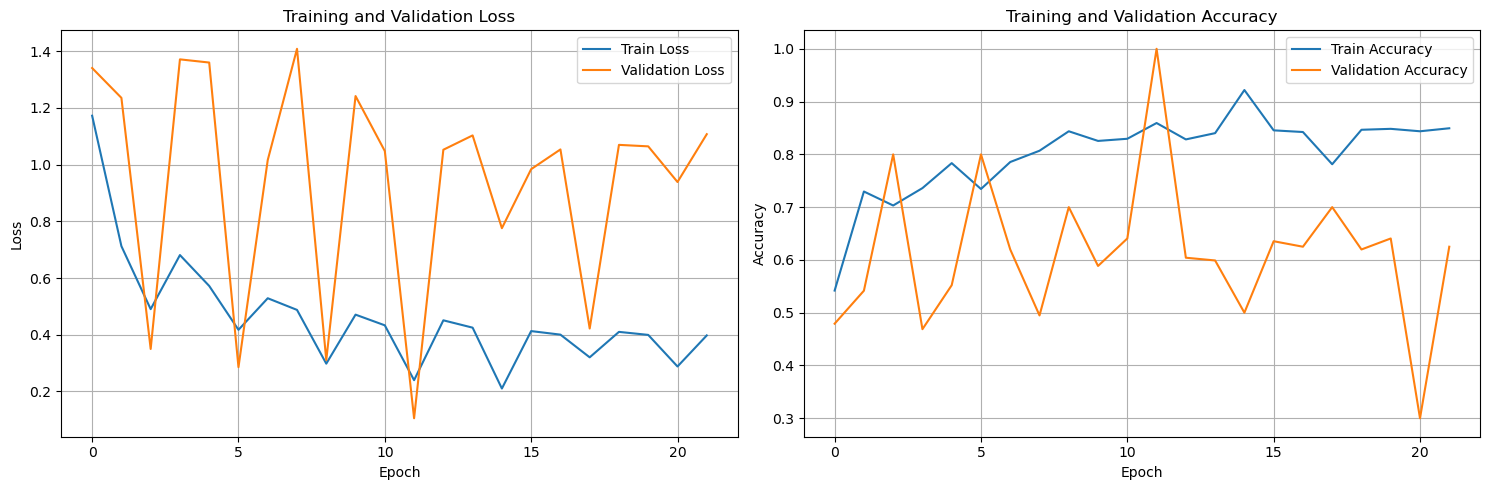

In [ ]:
plot_training_curves(history)

In [9]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.preprocessing import image
img= image.load_img("./data/Testing/no_tumor/image(10).jpg",target_size=(224,224))

x= image.img_to_array(img)
x=x/255
x= np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
img_data.shape
preds= model_02.predict(x)
preds= np.argmax(preds, axis=1)
if preds==1:
    preds="The image is glioma Tumor"
elif preds==2:
    preds="The image is meningioma Tumor"
elif preds==3:
    preds="The image is No Tumor"
else:
    preds="The image is pituitary tumor"
print(preds)

NameError: name 'model_02' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[[6.2575980e-33 5.8675843e-04 9.9941325e-01 3.1219552e-10]]


<h3 style='color:green;'>Predicted class: no_tumor</h3>

<h3 style='color:blue;'>Confidence: 99.94%</h3>

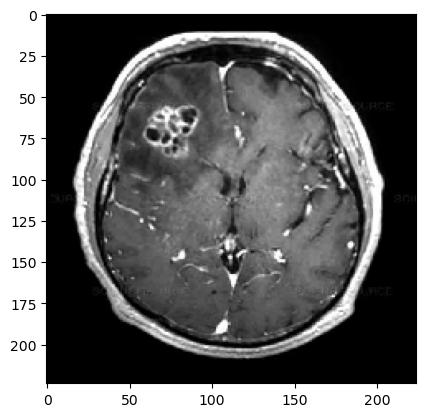

In [ ]:
from IPython.display import display, Markdown
imagePath = "./data/Testing/glioma_tumor/image(21).jpg"

img = image.load_img(imagePath, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model_02.predict(x)

print(predictions)

class_labels = ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']


predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

markdown_text = f"<h3 style='color:green;'>Predicted class: {predicted_class_label}</h3>"
display(Markdown(markdown_text))

markdown_text2 = f"<h3 style='color:blue;'>Confidence: {confidence*100:.2f}%</h3>"
display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()

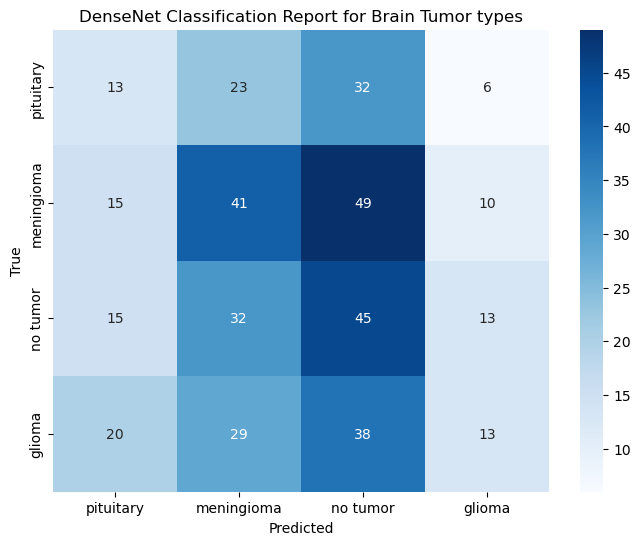

In [ ]:
import matplotlib.pyplot as plt

target_names= ['pituitary', 'meningioma','no tumor', 'glioma']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the classification report
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DenseNet Classification Report for Brain Tumor types")
plt.show()

# Save the figure as a PNG image
fig.savefig("./Classification_Report_DenseNet.png")

In [ ]:
# Print the classification report
print("DenseNet Classification report:")

# Print the classification report with labels
# Get the class labels
target_names= ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']

print(classification_report(y_true, y_pred, target_names=target_names))


DenseNet Classification report:
                  precision    recall  f1-score   support

 pituitary_tumor       0.21      0.18      0.19        74
meningioma_tumor       0.33      0.36      0.34       115
        no_tumor       0.27      0.43      0.33       105
    glioma_tumor       0.31      0.13      0.18       100

        accuracy                           0.28       394
       macro avg       0.28      0.27      0.26       394
    weighted avg       0.29      0.28      0.27       394



### EfficientNet based transfer learning and fine-tuned model

Adding regularization techniques such as dropout and adding more Dense layers to improves performance. I use the Adam optimizer and also experimented with RMSprop for the custom CNN

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm

train_datasets = './data/Training'
test_datasets = './data/Testing'

import numpy as np
# Load the data from the directories
X_train = []
y_train = []

image_size = 224

for folder in os.listdir(train_datasets):
    for file in os.listdir(os.path.join(train_datasets, folder)):
        img = keras.preprocessing.image.load_img(os.path.join(train_datasets, folder, file), target_size=(224,224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        X_train.append(img_array)
        y_train.append(folder)

for folder in os.listdir(test_datasets):
    for file in os.listdir(os.path.join(train_datasets, folder)):
        img = tf.keras.preprocessing.image.load_img(os.path.join(train_datasets, folder, file), target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        X_train.append(img_array)
        y_train.append(folder)

# Convert the lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)


labels = ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']

X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [14]:
# Load the EfficientNetB0 model pretrained on ImageNet without the top layers
from keras.layers import  Dropout,Dense,BatchNormalization

from tensorflow.keras import regularizers

efficientnetB0 = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                      include_top=False,
                                                      input_shape=(image_size, image_size, 3))
for layer in efficientnetB0.layers:
    layer.trainable= False



In [15]:
# Build the custom model on top of the EfficientNetB0 base
model = efficientnetB0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model_03 = tf.keras.models.Model(inputs=efficientnetB0.input, outputs = model)

In [16]:
model_03.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

In [17]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("./model/efficientnetB0.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)


In [18]:
nb_train_samples= 2870
nb_validation_samples= 394
epochs= 20
batch_size= 32

In [19]:
X_test.shape

(574, 224, 224, 3)

In [20]:
history = model_03.fit(X_train,y_train,validation_split=0.2, epochs=15, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.5872 - loss: 0.9750
Epoch 1: val_accuracy improved from -inf to 0.82979, saving model to ./model/efficientnetB0.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 805ms/step - accuracy: 0.5881 - loss: 0.9733 - val_accuracy: 0.8298 - val_loss: 0.4691 - learning_rate: 1.0000e-04
Epoch 2/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.8193 - loss: 0.4972
Epoch 2: val_accuracy improved from 0.82979 to 0.85880, saving model to ./model/efficientnetB0.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 766ms/step - accuracy: 0.8193 - loss: 0.4969 - val_accuracy: 0.8588 - val_loss: 0.3866 - learning_rate: 1.0000e-04
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8435 - loss: 0.4151
Epoch 3: val_accuracy improved from 0.85880 to 0.88201, saving model to ./model/efficientnetB0.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 102s 784ms/step - accuracy: 0.8436 - loss: 0.4149 - val_accuracy: 0.8820 - val_loss: 0.3449 - learning_rate: 1

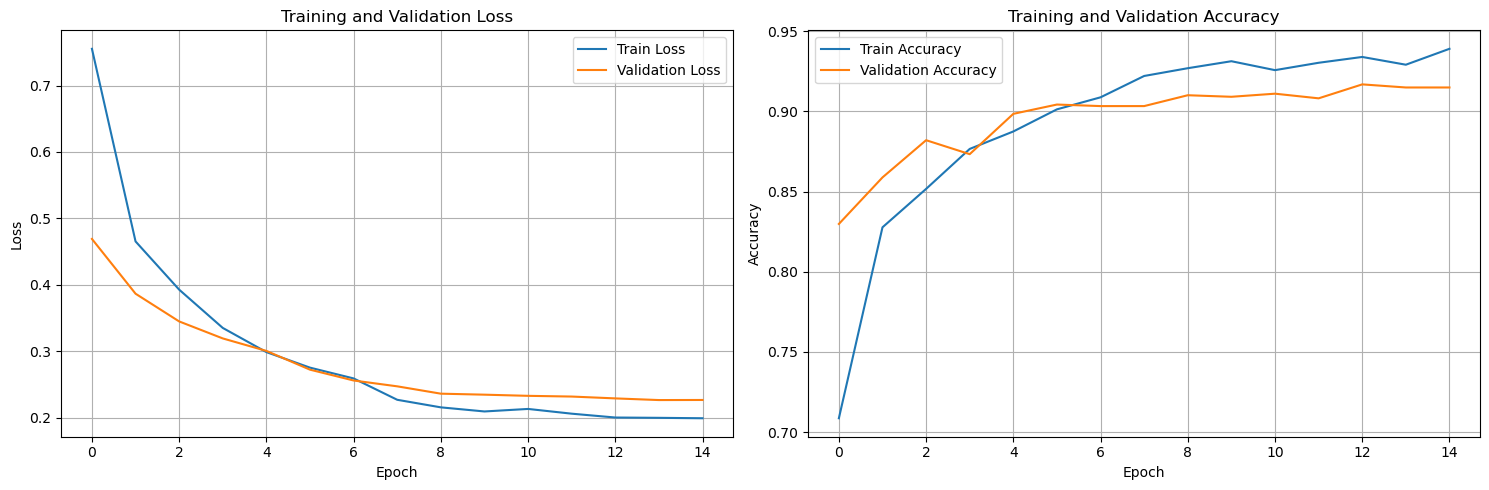

In [24]:
plot_training_curves(history)

In [29]:
def plot_confusion_classfication_report(model, name, history):
    target_names= ['pituitary', 'meningioma','no tumor', 'glioma']
    
    # Print the classification report
    print(" Classification report for model " + name )
    
    y_true_test = np.argmax(y_test, axis=1)
    y_pred_test = np.argmax(model.predict(X_test), axis=1) 
    
    print(classification_report(y_true_test, y_pred_test, target_names=target_names))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true_test, y_pred_test)
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the classification report
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Classification Report for Brain Tumor types")
    plt.show()
    
    report_name = "Classification_Report_" + name + ".png"
    # Save the figure as a PNG image
    fig.savefig(report_name)
    
    loss, accuracy = model.evaluate(X_test,y_test)
    print(f"Validation loss: {loss:.4f}")
    print(f"Validation accuracy: {accuracy:.4f}")
    
    f1_test = f1_score(y_true_test, y_pred_test,average="macro")
    print(f"F1 score: {f1_test:.4f}")

 Classification report for model EfficientNetB0
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step
              precision    recall  f1-score   support

   pituitary       0.96      0.99      0.97       159
  meningioma       0.87      0.90      0.89       165
    no tumor       1.00      0.92      0.96        78
      glioma       0.92      0.89      0.90       172

    accuracy                           0.93       574
   macro avg       0.94      0.93      0.93       574
weighted avg       0.93      0.93      0.93       574



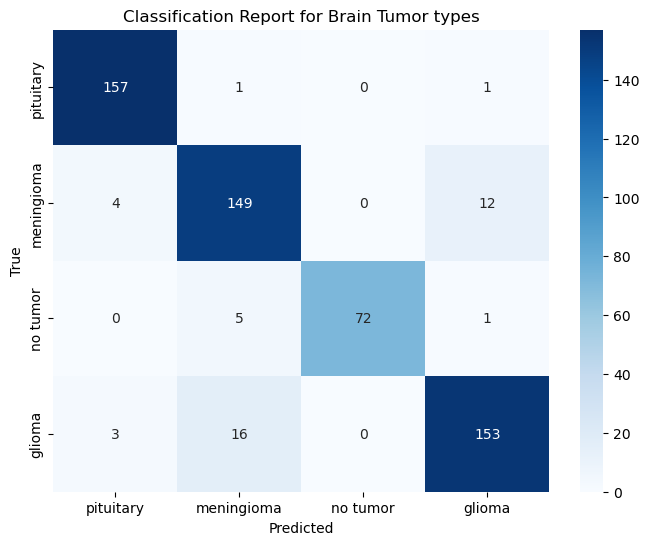

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.9274 - loss: 0.1912
Validation loss: 0.2105
Validation accuracy: 0.9251
F1 score: 0.9304


In [30]:
plot_confusion_classfication_report(model_03, "EfficientNetB0",history)

**Evaluation of EfficientNetB0 based CNN model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[9.111707e-03 9.059564e-01 8.480432e-02 1.276131e-04]]


<h3 style='color:green;'>Predicted class: meningioma_tumor</h3>

<h3 style='color:blue;'>Confidence: 90.60%</h3>

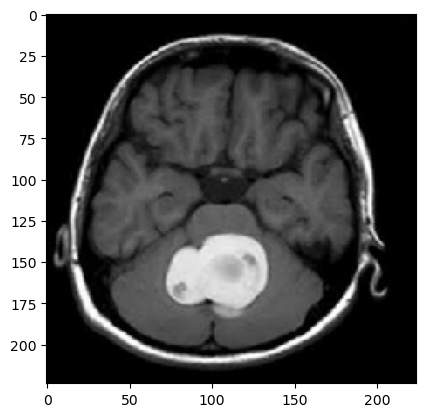

In [33]:
from IPython.display import display, Markdown
imagePath = "./data/Testing/meningioma_tumor/image(22).jpg"

img = image.load_img(imagePath, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model_03.predict(x)

print(predictions)

class_labels = ['pituitary_tumor', 'meningioma_tumor','no_tumor', 'glioma_tumor']


predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

markdown_text = f"<h3 style='color:green;'>Predicted class: {predicted_class_label}</h3>"
display(Markdown(markdown_text))

markdown_text2 = f"<h3 style='color:blue;'>Confidence: {confidence*100:.2f}%</h3>"
display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<h3 style='color:green;'>Predicted class: pituitary_tumor</h3>

<h3 style='color:blue;'>Confidence: 75.53%</h3>

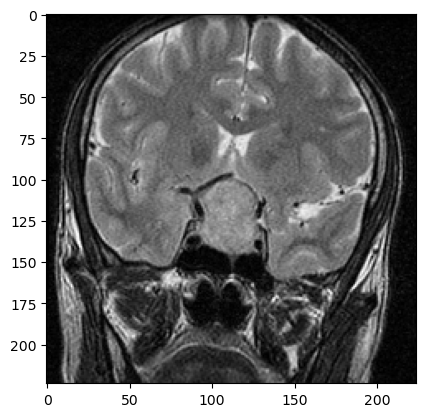

In [34]:
from IPython.display import display, Markdown
imagePath = "./data/Testing/pituitary_tumor/image(45).jpg"

img = image.load_img(imagePath, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

predictions = model_03.predict(x)

predicted_class_index = np.argmax(predictions,axis=1)[0]
predicted_class_label = labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

markdown_text = f"<h3 style='color:green;'>Predicted class: {predicted_class_label}</h3>"
display(Markdown(markdown_text))

markdown_text2 = f"<h3 style='color:blue;'>Confidence: {confidence*100:.2f}%</h3>"
display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()

### ResNet101

In [35]:
# Load the ResNet101 model pretrained on ImageNet without the top layers
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))

for layer in resnet.layers:
    layer.trainable=False

# Build the custom model on top of the ResNet101 base
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model_04 = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [36]:
# Compile the model
model_04.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='logs')

# Modelcheckpoint callback to save the best model 
checkpoint = ModelCheckpoint("ResNetB.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, 
                              min_delta=0.0001, verbose=1)

In [38]:
history = model_04.fit(X_train,y_train,validation_split=0.2, epochs=15, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5065 - loss: 1.4599
Epoch 1: val_accuracy improved from -inf to 0.81044, saving model to ResNetB.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5075 - loss: 1.4567 - val_accuracy: 0.8104 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7665 - loss: 0.6000
Epoch 2: val_accuracy improved from 0.81044 to 0.84623, saving model to ResNetB.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7666 - loss: 0.5997 - val_accuracy: 0.8462 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8284 - loss: 0.4566
Epoch 3: val_accuracy improved from 0.84623 to 0.89168, saving model to ResNetB.keras
130/130 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8284 - loss: 0.4566 - val_accuracy: 0.8917 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0

**ResNet Evaluation**

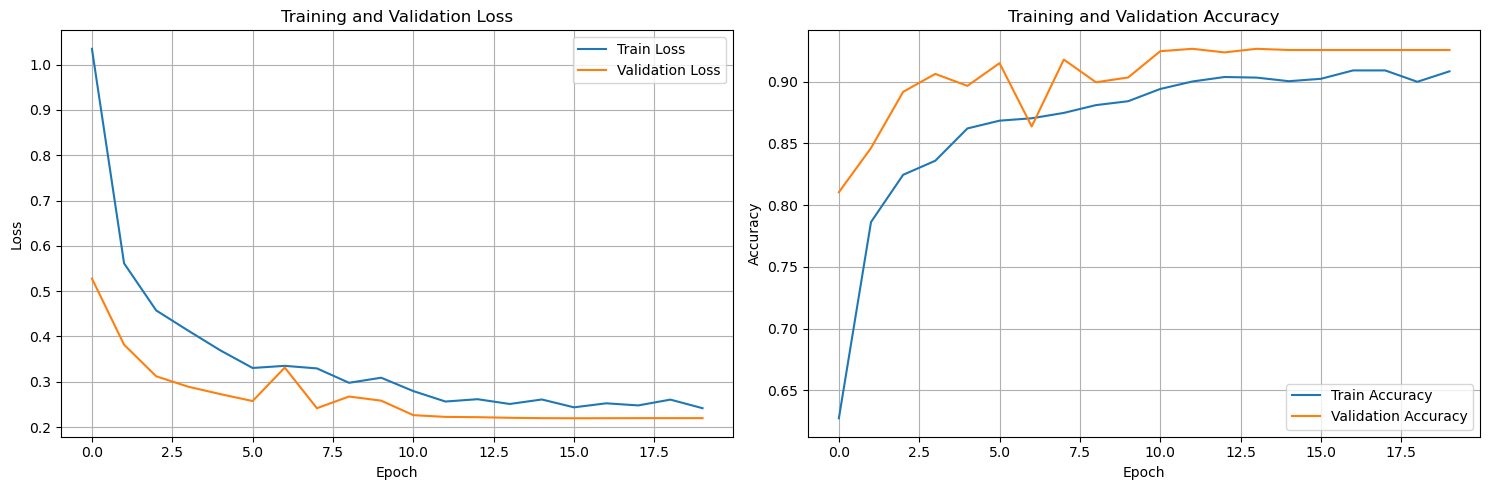

In [39]:
plot_training_curves(history)

 Classification report for model ResNet
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
              precision    recall  f1-score   support

   pituitary       0.97      1.00      0.98       159
  meningioma       0.87      0.93      0.90       165
    no tumor       1.00      0.95      0.97        78
      glioma       0.94      0.88      0.91       172

    accuracy                           0.94       574
   macro avg       0.95      0.94      0.94       574
weighted avg       0.94      0.94      0.94       574



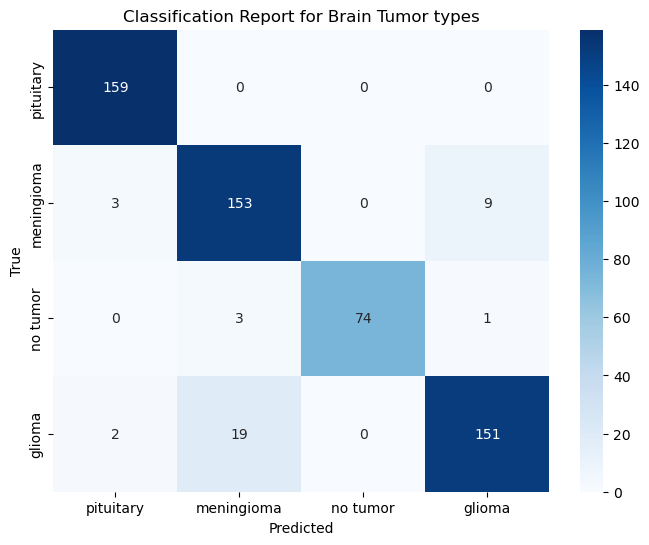

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9373 - loss: 0.1930
Validation loss: 0.2003
Validation accuracy: 0.9355
F1 score: 0.9413


In [40]:
plot_confusion_classfication_report(model_04, "ResNet",history)

### Model evaluation and summary of results 

I have created custom CNN models using transer learning on DenseNet, VGG 19 and EfficientNet-b0 and ResNet101 and compare the performance of these models.
using the accuracy, F1 scores and the confusion matrices.

Accuracy  metric is used to evaluate the performance of classification models 

        Accuracy = (Correct predictions)/ (Total number of predictions)

In the realm of multi-class classification problems, accuracy alone can paint a deceptively rosy picture, especially when the data is imbalanced.
Hence we also consider F1 score which is the harmonic mean of precision and recall.
F1 = 2 * (precision * recall) / (precision + recall).

##### Comparision of confusion matrices 
Confusion matrices indicate the counts of each error type a model made in the classification task. 

In these plots, 
-  0 is pituitary_tumor 
-  1 is meningioma_tumor
-  2 is no_tumor
-  3 is glioma_tumor

##### Summary
The F1 score of EfficientNetB0 based model is 0.93 and ResNet101 is 0.94
The accuracy of EfficientNetB0 based CNN model is 93% and ResNet101 is 90%

EfficientNetb0 often achieves comparable  accuracy to ResNet101 while requiring fewer computational resources. Its efficient use of parameters and improved scaling strategy contribute to its impressive performance.
It is more adaptable to small datasets, as it tends to generalize well even with limited training examples.

ResNet101 is a powerful architecture known for its strong performance especially on large-scale datasets, but it comes with higher computational costs. 
ResNet101 may struggle with overfitting when trained on small datasets due to its depth and parameter count. Additional regularization techniques or data augmentation may be necessary to prevent overfitting.

We can see that both ResNet101 and EfficientNetB0 based CCN model perform well in classifying the brain tumors based on the performance metric comparision.
The choice between the two would depends on the specific requirements which include available computational resources, and desired trade-offs between accuracy and efficiency.

In [41]:
import pandas as pd

# Create a DataFrame to store the results
df = pd.DataFrame({
    'Model': ['VGG19','DenseNet101', 'EfficientNetB0','ResNet101'],
    'Validation Accuracy': [0.53, 0.60, 0.93, 0.93],
    'Validation Loss': [1.60, 1.14, 0.21, 0.20],
})

# Set the index of the DataFrame
df.set_index('Model', inplace=True)

# Print the DataFrame
df

,Validation Accuracy,Validation Loss
Model,,
VGG19,0.53,1.60
DenseNet101,0.60,1.14
EfficientNetB0,0.93,0.21
ResNet101,0.90,0.23


### Conclusion

Using transfer learning with pre-trained models like DenseNet, VGG19, EfficientNetB0, and ResNet101 is a powerful approach to enhance classification accuracy, especially when dealing with complex tasks like brain tumor classification. Leveraging the pre-existing knowledge encoded in these models and fine-tuning them on a dataset specific to brain tumor classification, we improve the performance and achieve more accurate predictions.

Using the pretrained model and training it on a dataset specific to the brain tumor classfication task we can make classify and make predictions using the fine-tuned network.

EfficientNetB is chosen as the recommended model based on the evaluation to identifying and classifying brain tumors into three categories: pituitary, meningioma, and glioma, achieving an accuracy of 93%. 
This success demonstrates the effectiveness of transfer learning in addressing the challenges posed by small datasets and improving the accuracy of brain tumor detection.

By fine-tuning the pre-trained EfficientNetB0 model on a dataset tailored to brain tumor classification, clinicians can efficiently classify and make predictions regarding tumor types. This precise and rapid 
identification of tumor types can expedite treatment decisions, ultimately improving patient outcomes.

EfficientNetB0's balance between model size and accuracy makes it particularly suitable for brain tumor MRI image classification and segmentation, especially in resource-constrained environments. Its efficiency 
allows it to be deployed effectively even in settings with limited computational resources, making it a valuable tool for medical professionals.